# Reliable Signal Propagation

In [18]:
%load_ext autoreload
%autoreload 2

import os
import pickle
import copy
import numpy as np
from scipy.signal import find_peaks
import scipy.fftpack
from matplotlib import pyplot as plt
import seaborn as sns
import time

from src.network import Layer, PropagationNetwork, FullyConnectedLayerApprox, PropagationNetworkFCTorched
from src.ou_process import ouprocess_gaussian
from src.experiment import Experiment, MultiVariableExperiment
from src.lif import gaussian_kernel

sns.set()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


(This notebook contains the code for _____ )

Transmit a *common* signal through biologically realistic feed-forward networks (BrFNN) is a non-trivial problem. In this notebook, and corresponding paper, we show how the synaptic weight representation for a network doing this task can be reduced from an $N*N$ matrix to an $N*1$ vector.

*./src* contains the core code for the BrFNNs, while this notebook contains our analysis of the behaviour of the reduced synaptic weight model and the full synaptic weight model

In [19]:
def default_style():
    sns.set(style="whitegrid")
    sns.set_context("talk", font_scale=1.0)
    plt.rc('axes',edgecolor='#FFFFFF')

def graph_psth(spikes, num_timesteps, save=None, color="#2598B2", title=None, xlabel=None, ylabel=None):
    graph_size = 5
    sns.set(style="white")
    sns.set_context("talk", font_scale=1.0)

    plt.figure(figsize=(graph_size, graph_size))
    plt.rc('axes',edgecolor='#FFFFFF')

    in_spike_inds, in_spike_trial = np.where(spikes[:num_timesteps] > 0)
    in_spike_inds = in_spike_inds / float(num_timesteps)

    plt.scatter(in_spike_inds, in_spike_trial, s=6, marker='o', c=color)
    
    if title is not None:
        plt.title(title)
    if xlabel is not None:
        plt.xlabel(xlabel)
    if ylabel is not None:
        plt.ylabel(ylabel)

    if save is not None:
        plt.savefig(save)
    else:
        plt.show()
    plt.close()
    
    default_style()

def graph_firing_rates(in_fr, out_fr, num_timesteps, save=None, in_color="#888888", out_color='#189B48'):
    sns.set(style="white")
#     sns.set_context("talk", font_scale=2.5)
    plt.rc('axes',edgecolor='#FFFFFF')

    t = np.arange(0, 1.0, 1e-4)

    plt.figure(figsize=(5,4))
    plt.ylim(top=60)

    plt.plot(t, in_fr.mean(1).numpy()[:num_timesteps], c=in_color, lw=5.0)
    plt.plot(t, out_fr.mean(1).numpy()[:num_timesteps], c=out_color, lw=5.0)

    sns.despine()
    
    if save is not None:
        plt.savefig(save)
    else:
        plt.show()
    plt.close()
    
    default_style()

In [46]:
NUM_NEURONS = 200
tau_V = 10
R = 1 # MOhm
EL = -70.0
V_th = -40.0
dt = 0.1 # msec
t_stop = 3.0e3

INP_OU_TAU = 50.0

RESULTS_DIR = "./results"
GRAPHS_DIR = "./graphs"

default_style()

We attempt to transmit a 

Text(0, 0.5, 'Current (pA)')

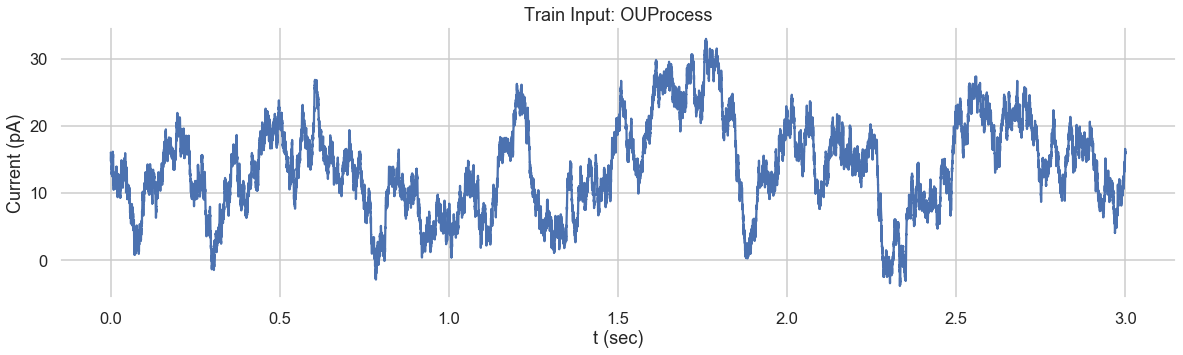

In [35]:
# INPUT: Slow Signal
start_time = time.time()

t = np.arange(0, t_stop * 1.0e-3, 1.0e-4)
input_slow, _ = ouprocess_gaussian(INP_OU_TAU, dt, t_stop, 1)
i_inj = 16.0 + 6.0*input_slow

plt.figure(figsize=(20,5))
plt.plot(t, i_inj)
plt.title("Train Input: OUProcess")
plt.xlabel("t (sec)")
plt.ylabel("Current (pA)")

Text(0, 0.5, 'Current (pA)')

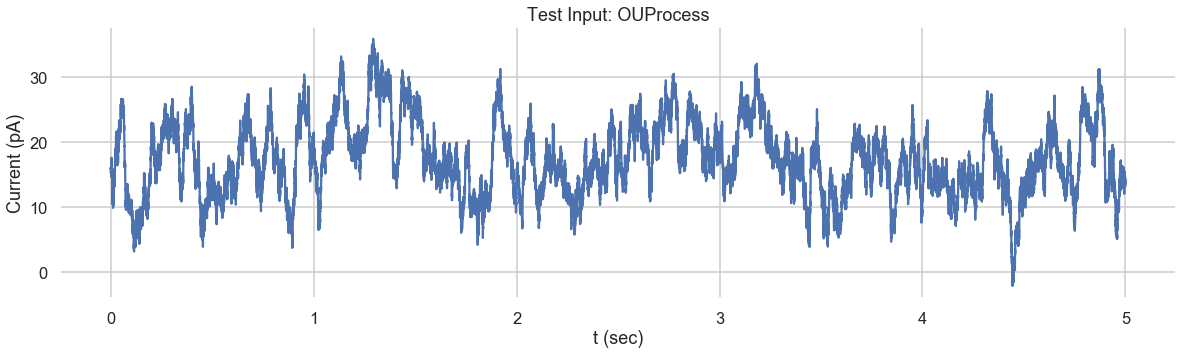

In [39]:
test_t = np.arange(0, test_t_stop * 1.0e-3, 1.0e-4)

test_input_slow, _ = ouprocess_gaussian(INP_OU_TAU, dt, test_t_stop, 1)
test_i_inj = 16.0 + 6.0*test_input_slow

plt.figure(figsize=(20,5))
plt.plot(test_t, test_i_inj)
plt.title("Test Input: OUProcess")
plt.xlabel("t (sec)")
plt.ylabel("Current (pA)")

In [22]:
LOAD_LAYER = True
load_layer_file = "poc1a__neurons=200__trials=200__input=tau_50_same__t_stop=5000_msecs"

test_t_stop = 5000.0

if LOAD_LAYER:
    experiment = Experiment.load(RESULTS_DIR, load_layer_file)
    layer = experiment.layer
else:
    layer = Layer(NUM_NEURONS)
    layer.train(i_inj=i_inj, exp_output=i_inj, dt=dt, t_stop=t_stop)

start_time = time.time()
out, V, F_binary, F_synaptic = layer.output(test_i_inj, dt, test_t_stop)
_, spike_out = layer.spike(out, dt, test_t_stop, int_noise_regen=True)
print(time.time() - start_time)

8.546319246292114


In [23]:
start_time = time.time()
in_fr = layer.firing_rate(F_binary, dt, test_t_stop)
out_fr = layer.firing_rate(spike_out, dt, test_t_stop)
print(time.time() - start_time)

171.15651988983154


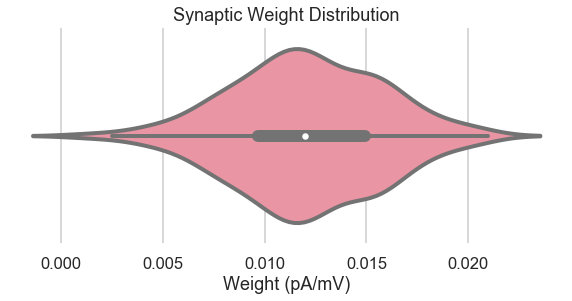

In [24]:
# Weight Distribution

plt.figure(figsize=(10,4))

sns.violinplot(layer.W, linewidth=4, color=sns.xkcd_rgb["rose pink"])
plt.title("Synaptic Weight Distribution")
plt.xlabel("Weight (pA/mV)")
# plt.savefig((os.path.join(GRAPHS_DIR, "rednet_weights.png")))
plt.show()

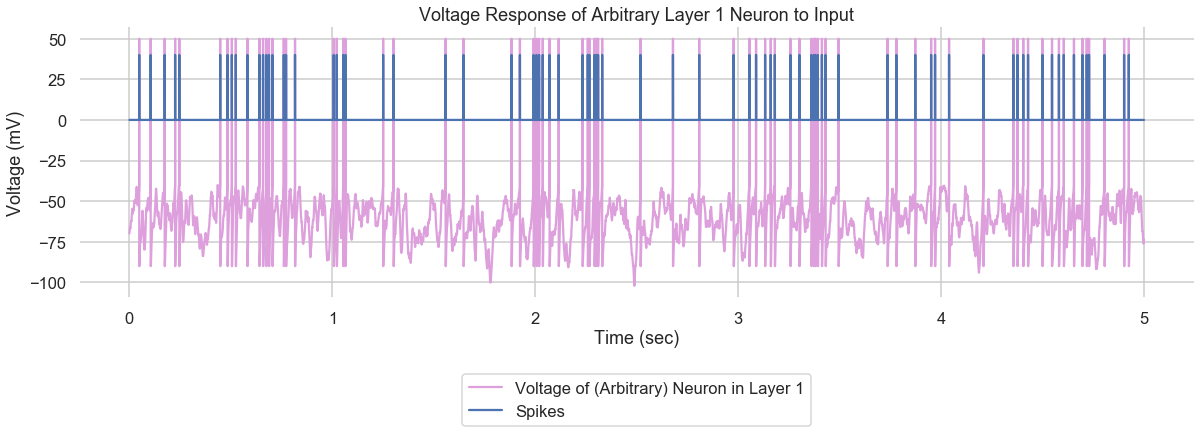

In [42]:
# Voltage + Spike graph
neuron_ind = 10
t_i = 0
t_f = len(test_t)

plt.figure(figsize=(20,5))
plt.plot(test_t, V[t_i:t_f, neuron_ind], color='plum', label="Voltage of (Arbitrary) Neuron in Layer 1")
plt.plot(test_t, F_binary[t_i:t_f, neuron_ind] * 40.0, label="Spikes")
plt.title("Voltage Response of Arbitrary Layer 1 Neuron to Input")
plt.xlabel("Time (sec)")
plt.ylabel("Voltage (mV)")
plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.5))
# TODO: LEGEND
plt.show()

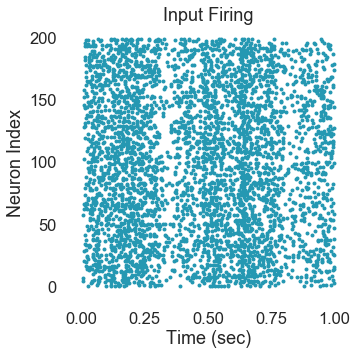

In [26]:
graph_psth(F_binary, 10000, title="Input Firing", xlabel="Time (sec)", ylabel="Neuron Index") # (os.path.join(GRAPHS_DIR, "verif_fcl_approx_input_spikes.png")

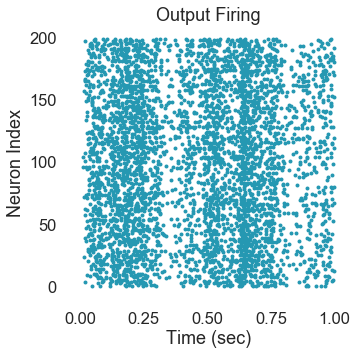

In [27]:
graph_psth(spike_out, 10000, title="Output Firing", xlabel="Time (sec)", ylabel="Neuron Index") # (os.path.join(GRAPHS_DIR, "verif_fcl_approx_output_spikes.png"))

In [28]:
in_fr.shape

torch.Size([50000, 200])

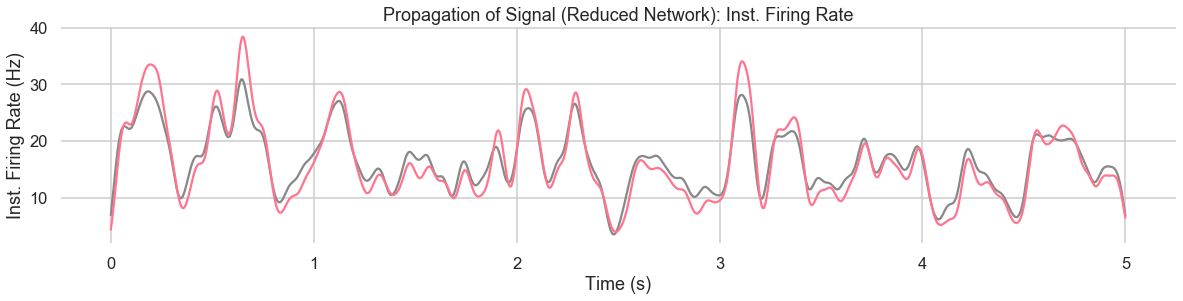

In [45]:
# sns.set(style="white")
# sns.set_context("talk", font_scale=1.5)
# plt.rc('axes',edgecolor='#666666')

plt.figure(figsize=(20,4))
plt.plot(test_t, in_fr.mean(1).numpy(), "#888888")
plt.plot(test_t, out_fr.mean(1).numpy(), '#FF7590')

plt.title("Propagation of Signal (Reduced Network): Inst. Firing Rate")
plt.xlabel("Time (s)")
plt.ylabel("Inst. Firing Rate (Hz)")

sns.despine()

plt.show()
# plt.savefig((os.path.join(GRAPHS_DIR, "fig4c-fr-redn_unc.png")))

In [48]:
LOAD_IEEE_REDUCEDNET_CF = False
load_ieee_reducednet_cf_file = "ieee_rednet_cf__neurons=200__trials=200__input=tau_" + str(INP_OU_TAU) + "_regenerated__t_stop=5000_msecs"

In [49]:
if LOAD_IEEE_REDUCEDNET_CF:
    experiment = Experiment.load(RESULTS_DIR, load_ieee_reducednet_cf_file)
else:
    NUM_TRIALS = 200
    test_t_stop = 5000.0

    num_t = np.arange(0.0, test_t_stop, dt).shape[0]
    inputs = np.empty((num_t, NUM_TRIALS))

    for i in range(NUM_TRIALS):
        input_slow, _ = ouprocess_gaussian(INP_OU_TAU, dt, test_t_stop, 1)
        i_inj = 16.0 + 6.0*input_slow
        inputs[:,i] = i_inj.flatten()

    experiment = Experiment(inputs, layer, NUM_TRIALS, dt, test_t_stop)
    spikes = experiment.run()
    experiment.save(RESULTS_DIR, load_ieee_reducednet_cf_file)

Trial  0
10  Iter time:  5.243617296218872
Total time:  5.243617296218872


Trial  10
10  Iter time:  56.06110644340515
Total time:  61.30825686454773


Trial  20
10  Iter time:  55.12780690193176
Total time:  116.43606376647949


Trial  30
10  Iter time:  55.87751746177673
Total time:  172.31358122825623


Trial  40
10  Iter time:  52.84113430976868
Total time:  225.1547155380249


Trial  50
10  Iter time:  54.49277114868164
Total time:  279.64748668670654


Trial  60
10  Iter time:  54.744889974594116
Total time:  334.39237666130066


Trial  70
10  Iter time:  62.183297634124756
Total time:  396.5756742954254


Trial  80
10  Iter time:  57.80171728134155
Total time:  454.37739157676697


Trial  90
10  Iter time:  59.24988651275635
Total time:  513.6272780895233


Trial  100
10  Iter time:  59.829139709472656
Total time:  573.4574184417725


Trial  110
10  Iter time:  59.65921998023987
Total time:  633.1166384220123


Trial  120
10  Iter time:  63.99610090255737
Total time:  697.11273

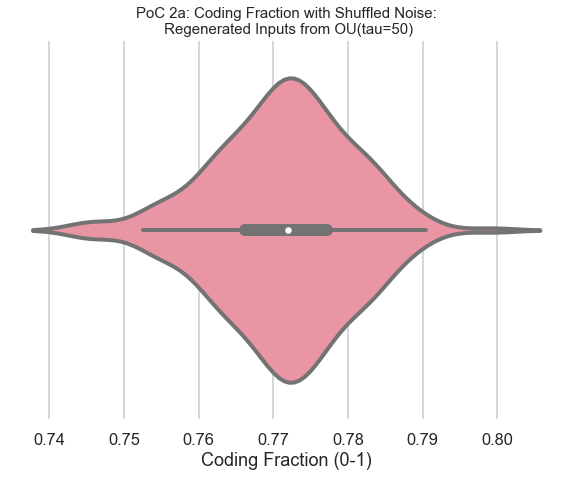

In [50]:
efficiencies = np.empty((experiment.num_trials))

for i in range(experiment.num_trials):
    efficiencies[i] = 1.0 - np.linalg.norm(experiment.outputs[:, i]-experiment.inputs[:, i])/np.linalg.norm(experiment.inputs[:, i])

plt.figure(figsize=(10,7))

sns.violinplot(efficiencies, linewidth=4, color=sns.xkcd_rgb["rose pink"])
plt.title('PoC 2a: Coding Fraction with Shuffled Noise:\n Regenerated Inputs from OU(tau=50)', fontsize=15)
plt.xlabel('Coding Fraction (0-1)')

plt.show()
# plt.savefig(os.path.join(GRAPHS_DIR, load_poc_2a_file + ".png"))